In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import random
from PIL import Image
from tqdm import tqdm
from imblearn.over_sampling import RandomOverSampler

import tensorflow as tf
from sklearn.model_selection import train_test_split

from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.utils import plot_model
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

zipfile = "/content/drive/MyDrive/TRAFFIC SIGN/archive.zip"

if not os.path.exists("dataset"):
    os.makedirs("dataset")

!unzip -q "{zipfile}" -d "dataset"

!ls dataset

In [2]:
main_dir = "/kaggle/input/gtsrb-german-traffic-sign/"

label_map = {
    '0': '20_speed',
    '1': '30_speed',
    '2': '50_speed',
    '3': '60_speed',
    '4': '70_speed',
    '5': '80_speed',
    '6': '80_lifted',
    '7': '100_speed',
    '8': '120_speed',
    '9': 'no_overtaking_general',
    '10': 'no_overtaking_trucks',
    '11': 'right_of_way_crossing',
    '12': 'right_of_way_general',
    '13': 'give_way',
    '14': 'stop',
    '15': 'no_way_general',
    '16': 'no_way_trucks',
    '17': 'no_way_one_way',
    '18': 'attention_general',
    '19': 'attention_left_turn',
    '20': 'attention_right_turn',
    '21': 'attention_curvy',
    '22': 'attention_bumpers',
    '23': 'attention_slippery',
    '24': 'attention_bottleneck',
    '25': 'attention_construction',
    '26': 'attention_traffic_light',
    '27': 'attention_pedestrian',
    '28': 'attention_children',
    '29': 'attention_bikes',
    '30': 'attention_snowflake',
    '31': 'attention_deer',
    '32': 'lifted_general',
    '33': 'turn_right',
    '34': 'turn_left',
    '35': 'turn_straight',
    '36': 'turn_straight_right',
    '37': 'turn_straight_left',
    '38': 'turn_right_down',
    '39': 'turn_left_down',
    '40': 'turn_circle',
    '41': 'lifted_no_overtaking_general',
    '42': 'lifted_no_overtaking_trucks'
}

In [3]:
traincsv = pd.read_csv("/kaggle/input/gtsrb-german-traffic-sign/Train.csv")
print(traincsv.head(5))

   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  


In [4]:
traincsv.drop(['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2'], axis=1, inplace=True)
print(traincsv.head(5))

   ClassId                            Path
0       20  Train/20/00020_00000_00000.png
1       20  Train/20/00020_00000_00001.png
2       20  Train/20/00020_00000_00002.png
3       20  Train/20/00020_00000_00003.png
4       20  Train/20/00020_00000_00004.png


In [5]:
num_classes = len(traincsv['ClassId'].unique())
print("Number of classes:", num_classes)

Number of classes: 43


In [6]:
print(f"{'class id':<10} {'label name':<10}\n")
for i in range(5):
    label_name = label_map[str(i)]
    print(f"{i:^10} {label_name:<10}")

class id   label name

    0      20_speed  
    1      30_speed  
    2      50_speed  
    3      60_speed  
    4      70_speed  


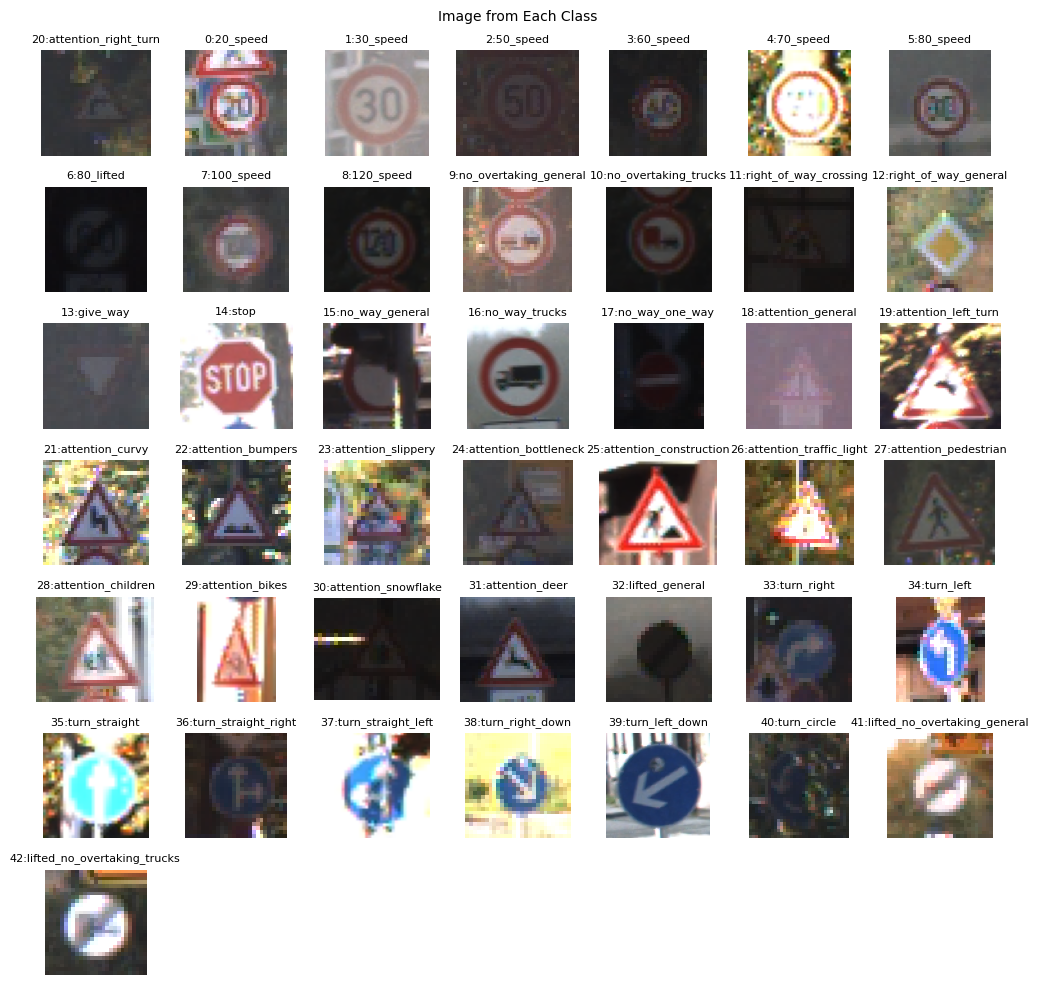

In [7]:
class_labels = traincsv['ClassId'].unique()

fig, axs = plt.subplots(7, 7, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5)

for i, label_id in enumerate(class_labels):
    img_path = main_dir + traincsv[traincsv['ClassId'] == label_id]['Path'].iloc[0]

    img = plt.imread(img_path)

    label_name = label_map[str(label_id)]

    row_idx = i // 7
    col_idx = i % 7
    axs[row_idx, col_idx].imshow(img)
    axs[row_idx, col_idx].set_title(f"{label_id}:{label_name}",fontsize=8)
 
for ax in axs.flatten():
    ax.axis('off')
    
fig.suptitle('Image from Each Class', fontsize=10)  
fig.tight_layout()
plt.show()

In [8]:
data = []
labels = []

for row in tqdm(traincsv.itertuples(), total=len(traincsv), desc='Loading training data',position=0):
    label = str(row.ClassId)
    filename = row.Path
    img_path = os.path.join(main_dir, filename)
    img = Image.open(img_path)
    img = img.resize((32, 32))
    img = np.array(img)
    data.append(img)
    labels.append(label)

train_data = np.array(data)
train_labels = np.array(labels)

Loading training data: 100%|██████████| 39209/39209 [03:27<00:00, 188.94it/s]


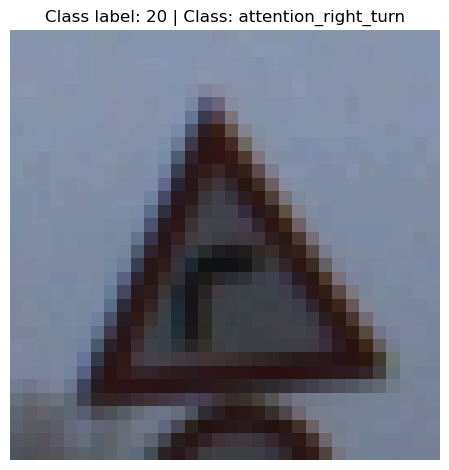

In [9]:
plt.imshow(train_data[100])
plt.axis('off')
plt.title(f"Class label: {train_labels[100]} | Class: {label_map[str(train_labels[100])]}")
plt.tight_layout()
plt.show()

In [10]:
print(train_data.shape, train_labels.shape)

(39209, 32, 32, 3) (39209,)


In [11]:
testcsv = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Test.csv')
print(testcsv.head(5))

   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/00002.png
3     27      29       5       5      22      24       33  Test/00003.png
4     60      57       5       5      55      52       11  Test/00004.png


In [12]:
testcsv.drop(['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2'], axis=1, inplace=True)
print(testcsv.head(5))

   ClassId            Path
0       16  Test/00000.png
1        1  Test/00001.png
2       38  Test/00002.png
3       33  Test/00003.png
4       11  Test/00004.png


In [13]:
data = []
labels = []
dir = '/kaggle/input/gtsrb-german-traffic-sign/'

for index, row in tqdm(testcsv.iterrows(), total=len(testcsv), desc='Loading test data'):
    img_path = row['Path']
    label = row['ClassId']
    
    img = Image.open(dir+img_path)
    img = img.resize((32, 32))
    img = np.array(img)
    
    data.append(img)
    labels.append(label)
        
test_data = np.array(data)
test_labels = np.array(labels)

Loading test data: 100%|██████████| 12630/12630 [01:04<00:00, 194.37it/s]


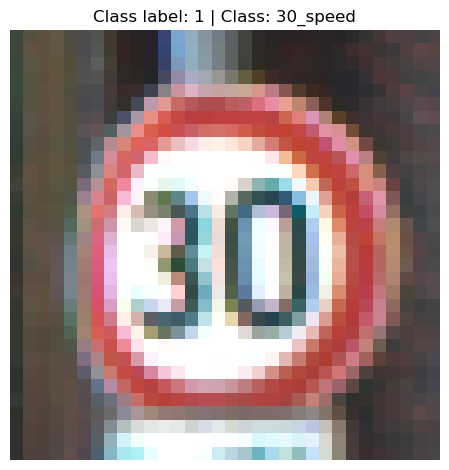

In [14]:
plt.imshow(test_data[1])
plt.axis('off')
plt.title(f"Class label: {test_labels[1]} | Class: {label_map[str(test_labels[1])]}")
plt.tight_layout()
plt.show()

In [15]:
print(test_data.shape, test_labels.shape)

(12630, 32, 32, 3) (12630,)


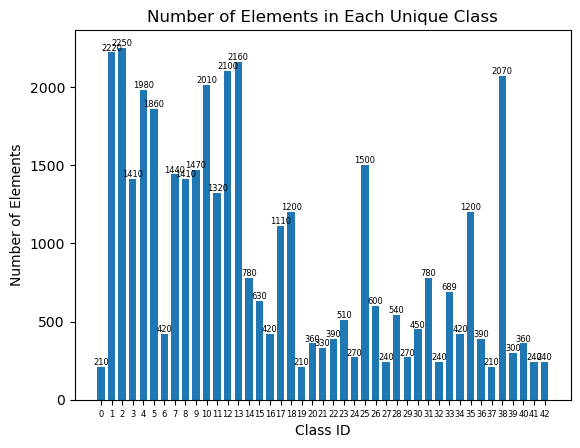

In [16]:
class_counts = traincsv['ClassId'].value_counts().sort_index()

plt.bar(class_counts.index, class_counts.values, width=0.7)

plt.xlabel('Class ID')
plt.ylabel('Number of Elements')
plt.title('Number of Elements in Each Unique Class')

plt.xticks(class_counts.index, fontsize=6)

for i, count in enumerate(class_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=6)

plt.show()

In [17]:
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size= 0.2, random_state=42)
print(train_data.shape, train_labels.shape)
print(val_data.shape, val_labels.shape)

(31367, 32, 32, 3) (31367,)
(7842, 32, 32, 3) (7842,)


In [18]:
print(train_labels[1])

28


In [19]:
train_labels = to_categorical(train_labels)
val_labels = to_categorical(val_labels)
test_labels = to_categorical(test_labels)

In [20]:
print(train_data.shape, train_labels.shape)
print(val_data.shape, val_labels.shape)
print(test_data.shape, test_labels.shape)

(31367, 32, 32, 3) (31367, 43)
(7842, 32, 32, 3) (7842, 43)
(12630, 32, 32, 3) (12630, 43)


In [21]:
print(train_labels[1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [22]:
train_generator = ImageDataGenerator(
    rescale=1./255.0,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
)

val_generator = ImageDataGenerator(
    rescale=1./255.0
)

test_data = test_data.astype('float32') / 255.0

In [23]:
train_iterator = train_generator.flow(train_data, train_labels, batch_size=64,shuffle=True)
val_iterator = val_generator.flow(val_data, val_labels, batch_size=64)


In [24]:
model = Sequential()   
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(32,32,3)))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.15))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.15))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(43, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          36928     
                                                        

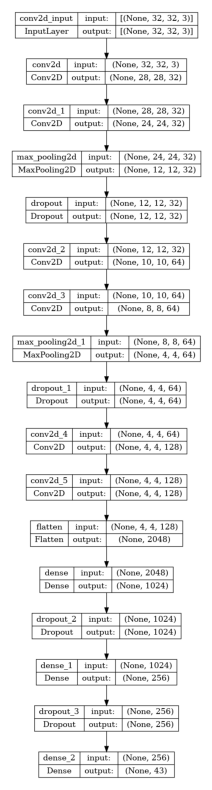

In [26]:
plot_model(model, show_shapes=True, to_file='model.png')
img = Image.open('model.png')
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [27]:
history = model.fit(train_iterator,
          batch_size=64,
          epochs=2,
          validation_data=val_iterator,
          callbacks=[ModelCheckpoint('model.h5', save_best_only=True)]
          )

Epoch 1/2
491/491 [==============================] - 126s 252ms/step - loss: 2.7407 - accuracy: 0.2173 - val_loss: 1.2692 - val_accuracy: 0.5854
Epoch 2/2
491/491 [==============================] - 123s 251ms/step - loss: 0.8797 - accuracy: 0.7151 - val_loss: 0.2434 - val_accuracy: 0.9229


In [28]:
model = load_model('model.h5')

<Figure size 640x480 with 0 Axes>

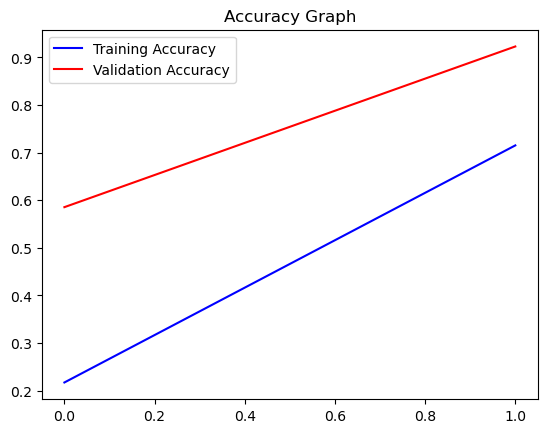

<Figure size 640x480 with 0 Axes>

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

<Figure size 640x480 with 0 Axes>

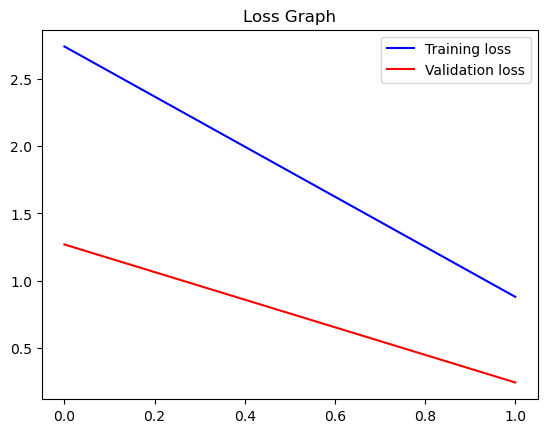

<Figure size 640x480 with 0 Axes>

In [30]:
acc = history.history['loss']
val_acc = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training loss')
plt.plot(epochs, val_acc, 'r', label='Validation loss')
plt.title('Loss Graph')
plt.legend()
plt.figure()

In [31]:
pred = model.predict(test_data)
print(test_labels[1])
print(pred[1])

395/395 [==============================] - 10s 26ms/step
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[2.9717126e-01 7.0260423e-01 7.3948118e-05 6.6914588e-08 5.7870198e-05
 7.9214566e-08 9.0131271e-11 4.9374819e-07 4.7089957e-06 2.9495272e-06
 2.4482385e-09 1.6829306e-09 1.4047070e-09 1.2631915e-08 2.8350735e-07
 9.1603908e-07 1.7055646e-08 3.3618061e-10 5.5959056e-08 2.0303009e-08
 1.6773305e-11 2.2189923e-08 1.3362417e-07 2.6612814e-09 1.1639878e-09
 9.5406358e-09 8.2467392e-05 5.0314566e-09 3.6643011e-09 3.7569134e-08
 1.3681098e-11 3.1721623e-09 3.5768244e-07 2.4062658e-14 1.5846196e-13
 1.0288636e-11 9.2610042e-14 7.2374052e-18 7.6805755e-13 8.5955427e-12
 1.3679442e-09 4.2690772e-08 7.7659192e-11]


In [32]:
pred_labels = np.argmax(pred, axis=1)
testlabels = np.argmax(test_labels, axis=1)

print(testlabels[1])
print(pred_labels[1])

1
1


In [55]:
precision = precision_score(testlabels, pred_labels, average='macro', zero_division=0)
recall = recall_score(testlabels, pred_labels, average='macro', zero_division=0)
f1 = f1_score(testlabels, pred_labels, average='macro', zero_division=0)
accuracy = accuracy_score(testlabels, pred_labels)

print("Precision score:", precision)
print("Recall score:", recall)
print("F1 score:", f1)
print("Accuracy score:", accuracy)

Precision score: 0.8249531128143031
Recall score: 0.84462763547167
F1 score: 0.8166502757021291
Accuracy score: 0.8844813935075218


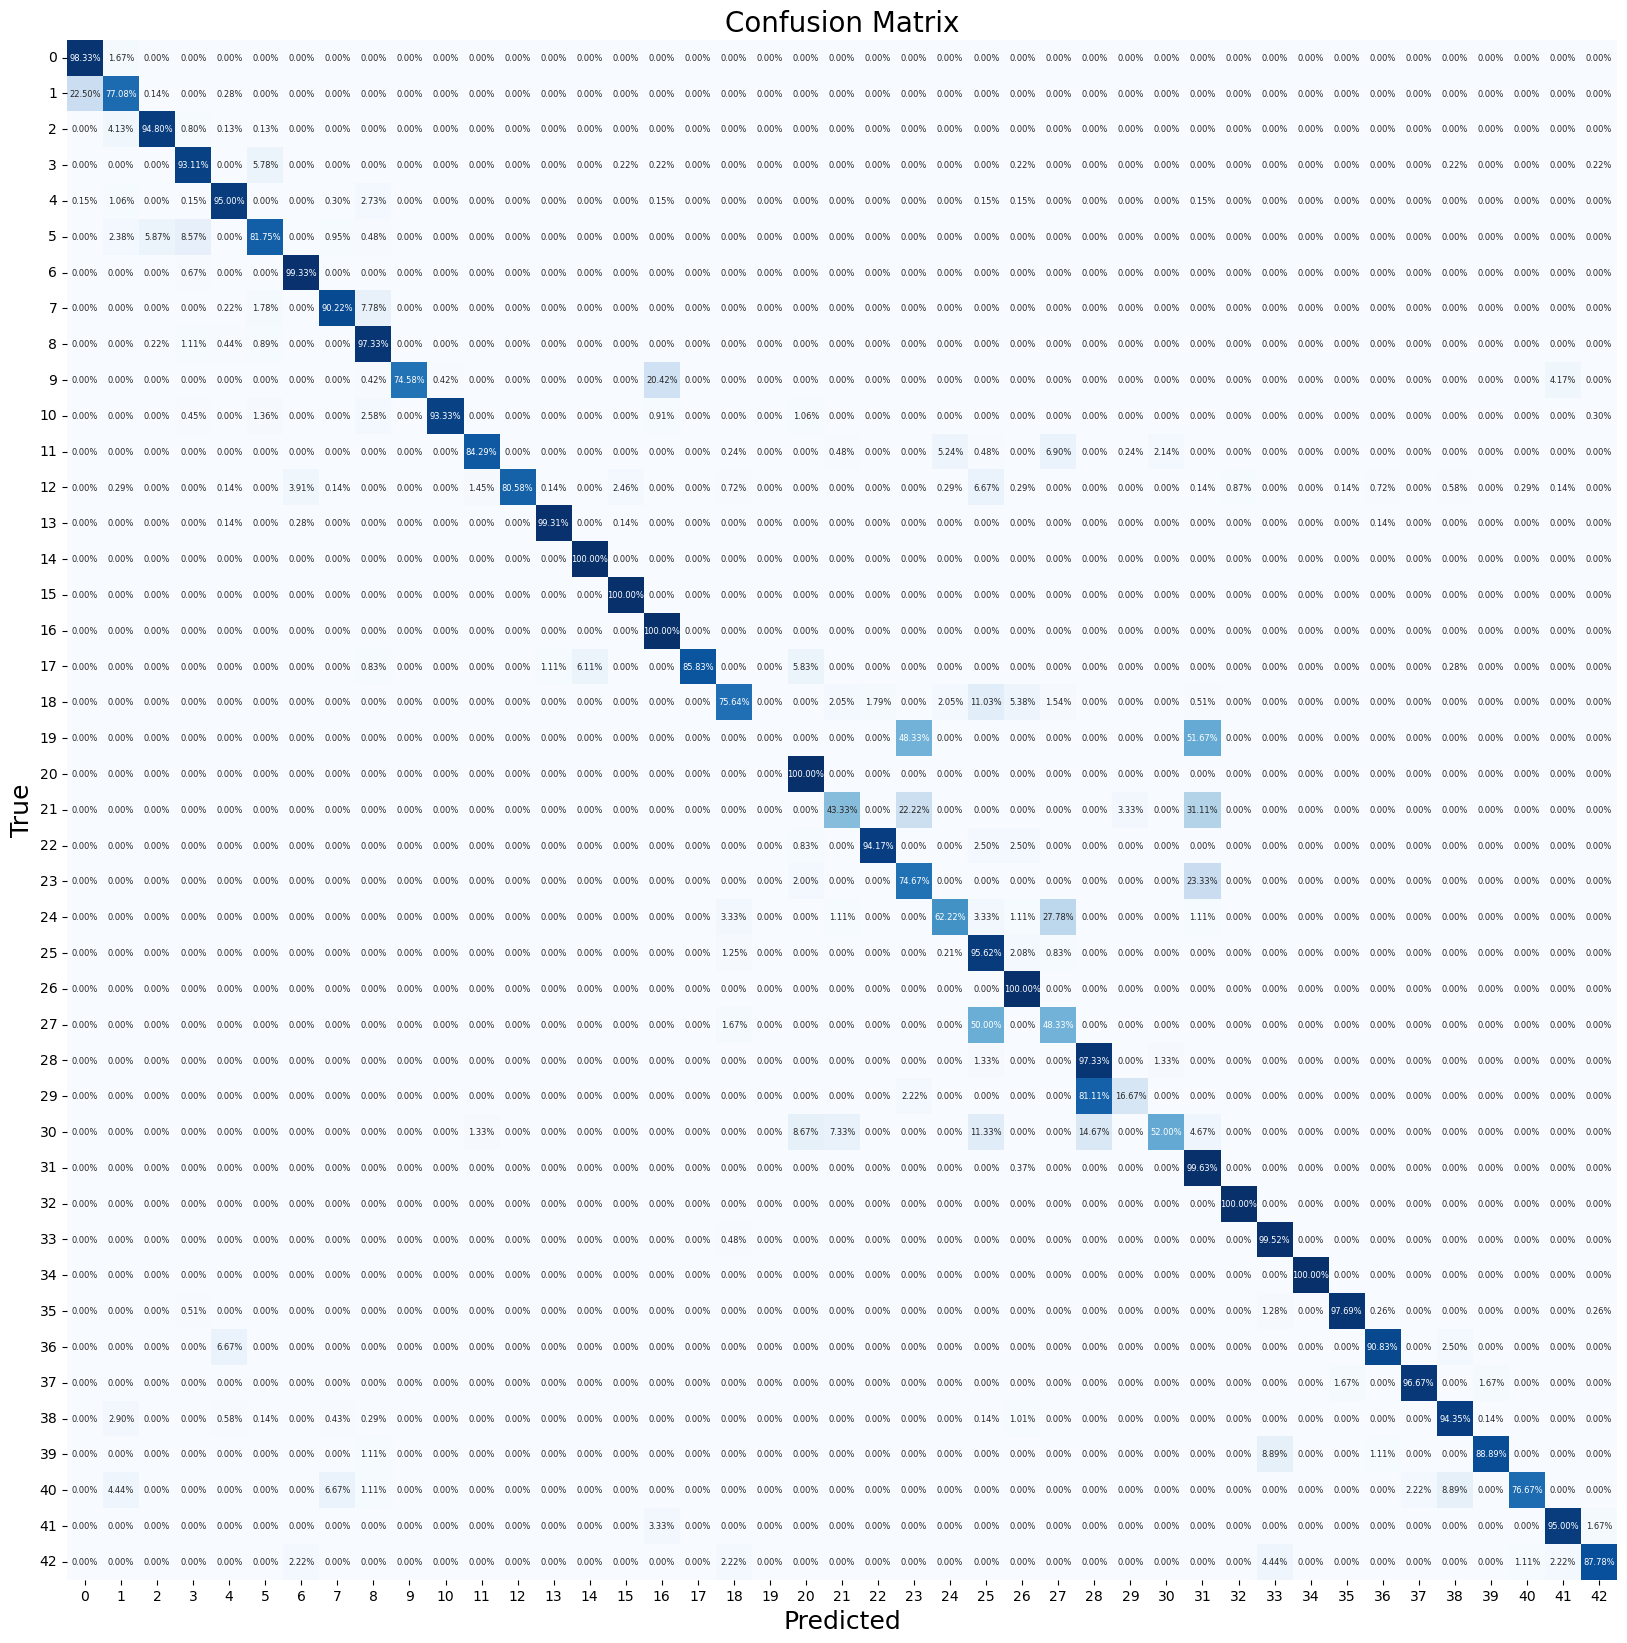

In [36]:
cm = confusion_matrix(testlabels, pred_labels)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sorted_classes = sorted(class_labels, key=lambda c: int(c))
fig, ax = plt.subplots(figsize=(20, 20))
sns.set(font_scale=0.5)
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', xticklabels=sorted_classes, yticklabels=sorted_classes, ax=ax, cbar=False)
ax.set_xlabel('Predicted', fontsize=18)
ax.set_ylabel('True', fontsize=18)
ax.set_xticklabels(sorted_classes, fontsize=10)
ax.set_yticklabels(sorted_classes, rotation=0, fontsize=10)
ax.set_title('Confusion Matrix', fontsize=20)
plt.show()

In [66]:
acc = np.diag(cm)
accuracy = acc / np.sum(cm, axis=1)

max_accuracy = np.max(accuracy)
print("Classes with highest accuracy: ",np.max(accuracy))
for i in range(len(label_map)):
    if accuracy[i] == max_accuracy:
        print(f"{i}: {label_map[str(i)]}")


Classes with highest accuracy:  1.0
14: stop
15: no_way_general
16: no_way_trucks
20: attention_right_turn
26: attention_traffic_light
32: lifted_general
34: turn_left


In [68]:
lowest_acc = np.argmin(accuracy)
print(f"Lowest accuracy is for class {lowest_acc} <{label_map[str(lowest_acc)]}> with accuracy: {accuracy[lowest_acc]:.2f}")

Lowest accuracy is for class 19 <attention_left_turn> with accuracy: 0.00


In [73]:
metacsv = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Meta.csv')
print(metacsv.head(5))

          Path  ClassId  ShapeId  ColorId SignId
0  Meta/27.png       27        0        0   1.32
1   Meta/0.png        0        1        0   3.29
2   Meta/1.png        1        1        0   3.29
3  Meta/10.png       10        1        0   3.27
4  Meta/11.png       11        0        0   1.22


In [74]:
metacsv.drop(columns=["ShapeId", "ColorId", "SignId"], inplace=True)
print(metacsv.head(5))

          Path  ClassId
0  Meta/27.png       27
1   Meta/0.png        0
2   Meta/1.png        1
3  Meta/10.png       10
4  Meta/11.png       11


In [75]:
def plot_image(img_path, true_label):
    img = load_img(img_path, target_size=(32,32))
    img_arr = img_to_array(img) / 255.0
    img_arr = img_arr.reshape(1, 32, 32, 3)

    pred_label = model.predict(img_arr) 
    true_class = label_map[true_label]
    pred_index = str(np.argmax(pred_label))
    predicted_class = label_map[pred_index]
    
    plt.figure()
    
    top_5 = np.argsort(pred_label[0])[::-1][:5] 
    pred_classes = [label_map[str(i)] for i in top_5]
    confidences = [pred_label[0][i] for i in top_5]

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 3))
    ax1.imshow(img)
    ax1.axis('off')
    ax1.set_title(f'True: {true_class}\nPredicted: {pred_classes[0]}', fontsize=10)

    y_pos = np.arange(len(pred_classes))
    ax2.barh(y_pos, confidences)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(pred_classes)
    ax2.invert_yaxis()
    ax2.set_xlabel('Confidence')
    ax2.set_title('Top 5 Predictions')
    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 27ms/step


<Figure size 640x480 with 0 Axes>

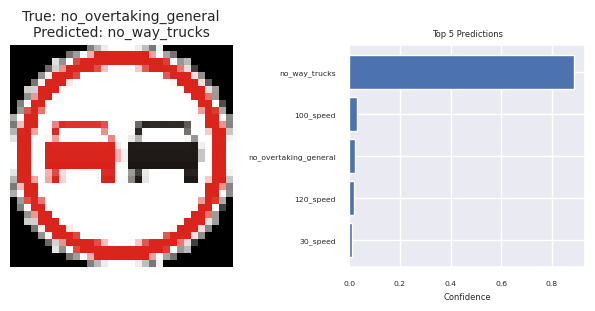

In [76]:
rn_index = np.random.randint(0, len(metacsv))
row = metacsv.iloc[rn_index]
dir = '/kaggle/input/gtsrb-german-traffic-sign/'
true_label = str(row['ClassId'])
img_path = dir + row['Path']

plot_image(img_path, true_label)


1/1 [==============================] - 0s 26ms/step


<Figure size 640x480 with 0 Axes>

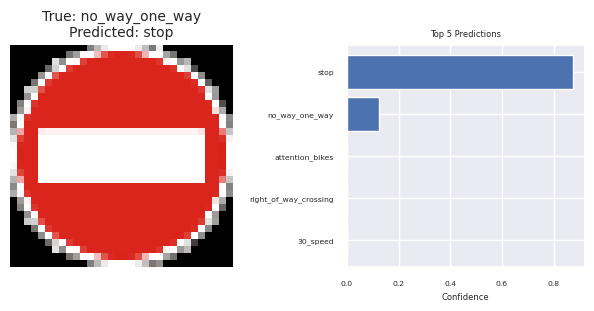

In [77]:
rn_index = np.random.randint(0, len(metacsv))
row = metacsv.iloc[rn_index]
true_label = str(row['ClassId'])
img_path = dir + row['Path']


plot_image(img_path, true_label)

1/1 [==============================] - 0s 26ms/step


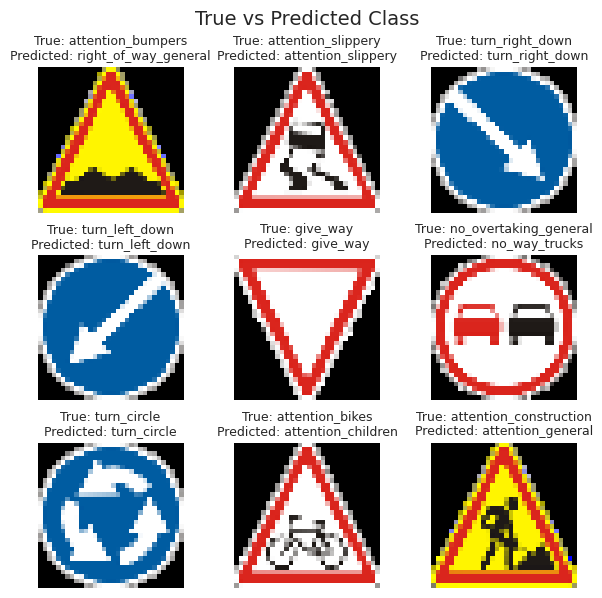

In [78]:
fig, axs = plt.subplots(3, 3, figsize=(6, 6))
samples = metacsv.sample(9)

for i, sample in enumerate(samples.values):
    img_path, true_label = sample[0], str(sample[1])
    
    img = load_img(dir+ img_path, target_size=(32,32))
    img_arr = img_to_array(img) / 255.0
    img_arr = img_arr.reshape(1, 32, 32, 3)
    
    pred_label = model.predict(img_arr)
    true_class = label_map[true_label]
    pred_index = str(np.argmax(pred_label))
    predicted_class = label_map[pred_index]
    
    ax = axs[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'True: {true_class}\nPredicted: {predicted_class}', fontsize=9)

fig.suptitle('True vs Predicted Class', fontsize=14)
fig.tight_layout()
plt.show()